## 동전 인식 분류

In [1]:
%cd /content/drive/MyDrive/kdt_240424/m8_vision응용

/content/drive/MyDrive/kdt_240424/m8_vision응용


In [2]:
from google.colab.patches import cv2_imshow

#### 오픈 연산 (cv2.MORPH_OPEN)
오픈 연산은 침식 연산(erode) 다음에 팽창 연산(dilate)을 수행하는 것으로 구성됩니다. 이 연산은 다음과 같은 효과를 가집니다:

- 작은 객체나 노이즈를 제거합니다.
- 두 객체 사이의 얇은 연결을 끊습니다.
- 객체의 경계를 부드럽게 합니다.

[ 연산 과정 ]
- 침식 연산: 커널이 위치한 모든 픽셀이 커널과 일치할 때만 원본 이미지의 중심 픽셀을 보존합니다. 이 과정에서 이미지의 작은 노이즈가 제거되고, 객체의 크기가 줄어듭니다.
- 팽창 연산: 커널과 하나라도 픽셀이 겹치는 경우, 원본 이미지의 중심 픽셀을 커널로 설정된 값으로 변경합니다. 침식에서 줄어든 객체의 크기가 다시 증가하면서, 노이즈는 제거된 상태를 유지합니다.

In [3]:
!pwd

/content/drive/MyDrive/kdt_240424/m8_vision응용


작업 Flow
- 이미지 전처리: 동전 이미지를 그레이스케일로 변환하고 블러링, 이진화를 통해 동전만 분리합니다.
- 윤곽선 검출: 전처리된 이미지에서 외곽선을 찾아 동전의 중심과 크기를 계산합니다.
- 원 그리기: 검출된 동전의 윤곽에 원을 그려 시각적으로 동전을 표시합니다.
- 결과 출력: 전처리된 이진화 이미지와 동전이 검출된 이미지를 Colab에서 출력합니다.

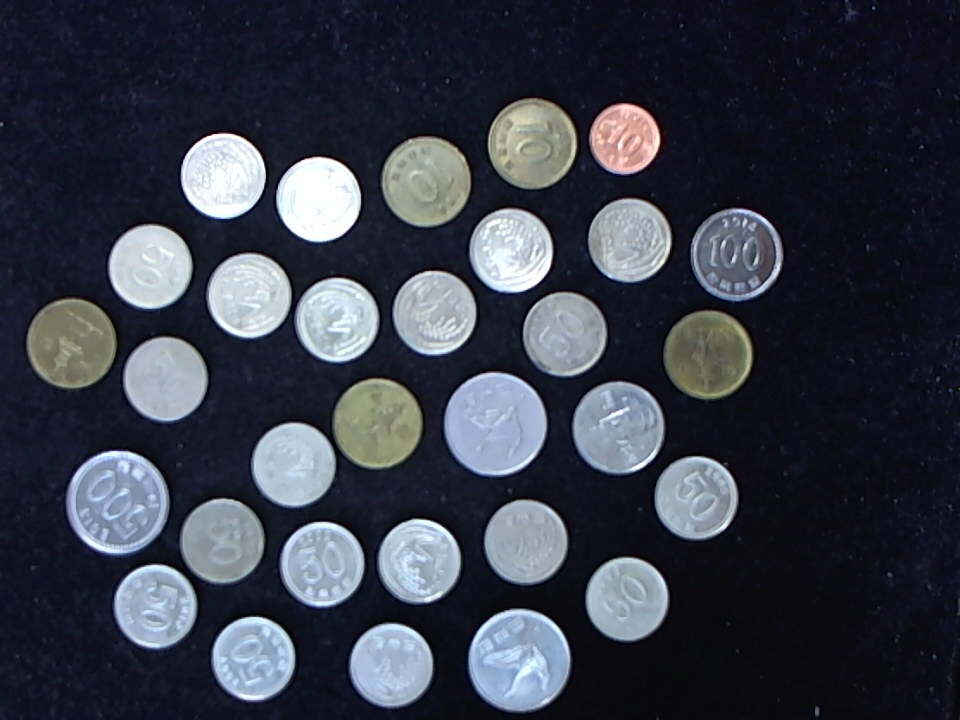

In [4]:
import numpy as np, cv2, time

fname = '/content/drive/MyDrive/kdt_240424/m8_vision응용/images/coin/65.png'
img = cv2.imread(fname)
cv2_imshow(img)

Preprocessed image:


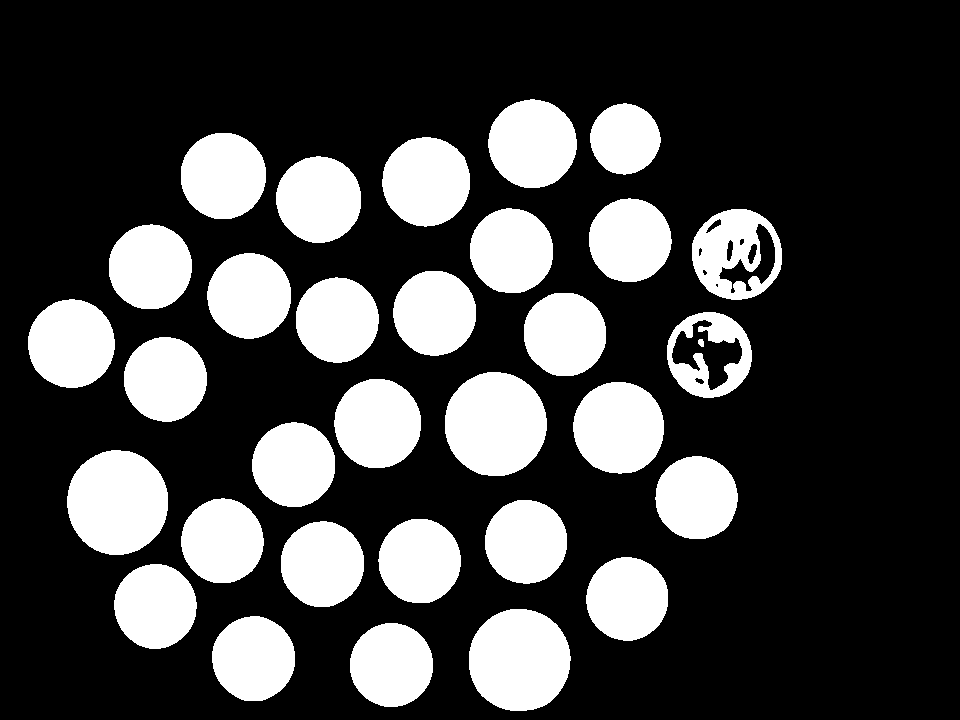

In [9]:
import numpy as np, cv2, time
import matplotlib.pyplot as plt

# 주어진 동전 영상 번호를 바탕으로 동전 영상을 읽고, 그레이스케일로 변환한 후 블러링과 이진화를 수행한 후 오픈 연산을 통해 작은 노이지를 제거
def preprocessing(coin_no): # 전처리 함수
    fname = 'images/coin/{0:02d}.png'.format(coin_no)
    image = cv2.imread(fname, cv2.IMREAD_COLOR) # 이미지 읽기
    # None이 두 번 사용된 이유는 이 함수가 기본적으로 이미지 두 개(image와 th_img)를 반환하기 때문
    if image is None : return None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 명암도 이미지 변환
    # 그레이스케일 이미지에 가우시안 블러를 적용, 이미지의 노이즈를 줄이고, 세부적인 정보를 감소시킴
    # 이진화 과정에서 배경과 동전을 더 잘 구분하기 위해 필요
    # X축과 Y축 방향으로 표준편차가 각각 2인 7x7 크기의 가우시안 커널을 사용하여 gray 이미지에 블러를 적용함을 의미
    gray = cv2.GaussianBlur(gray, (7,7), 2,2)
    # OTSU 알고리즘을 이용해 최적의 임계값을 자동으로 계산하고, 이를 기반으로 이진화를 수행
    # OTSU 알고리즘은 전체 이미지의 히스토그램을 분석하여, 전경(동전)과 배경을 구분하는 최적의 임계값을 찾습니다(사용자가 입력한 임계값 무시)
    flag = cv2.THRESH_BINARY + cv2.THRESH_OTSU
    # OTSU 알고리즘을 사용하여 자동으로 계산된 최적의 임계값으로 gray 이미지를 이진화하여, 그 결과를 th_img에 저장
    # 픽셀 값이 130이상인 경우 maxval 값(255)을 할당하고, 130 미만인 경우 0으로 설정
    # OTSU 알고리즘을 사용하여 최적의 임계값을 자동으로 계산하고, 그 값을 사용하여 이미지를 이진화
    _, th_img = cv2.threshold(gray, 130, 255, flag)
    # 3x3 크기의 구조 요소(커널)를 생성
    mask = np.ones((3,3), np.uint8)
    # 이진화된 이미지에서 작은 노이즈나 객체를 제거하고, 떨어져 있는 객체를 더 명확하게 분리하는 등의 전처리를 수행(열림 연산을 수행, 침식 후 팽창)
    th_img = cv2.morphologyEx(th_img, cv2.MORPH_OPEN, mask) # 열림 연산

    return image, th_img

image, th_img = preprocessing(65) # 전처리 수행
if image is None: raise Exception('이미지 파일 읽기 에러')

print("Preprocessed image:")
cv2_imshow(th_img)

Coin image:


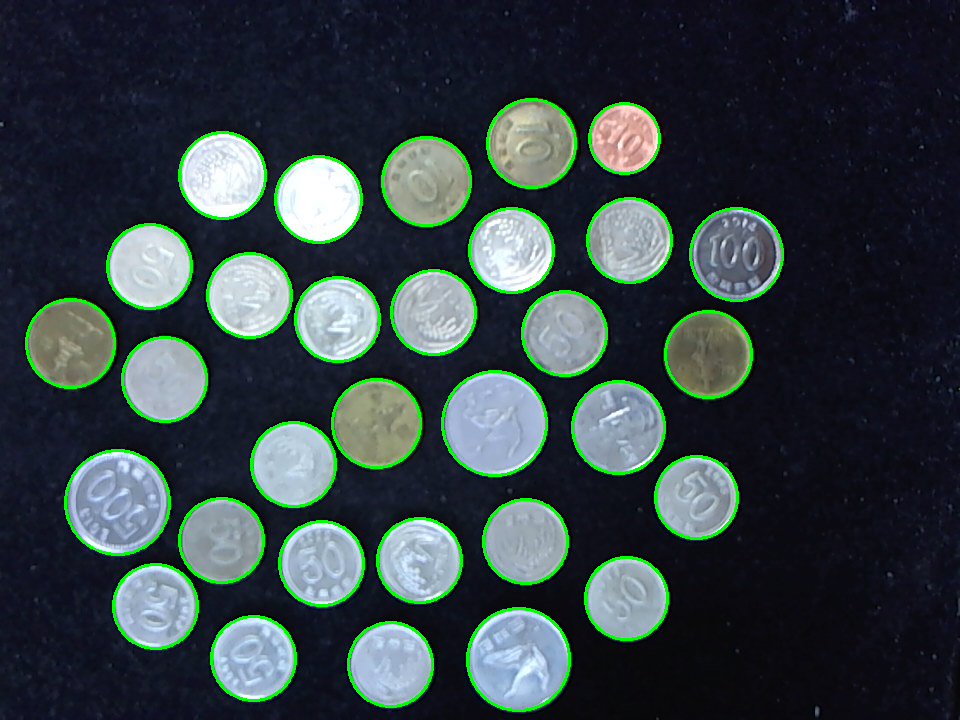

In [12]:
# 이미지에서 동전과 같은 원형 객체를 보다 효과적으로 검출하고, 노이즈로 인한 잘못된 검출을 최소화

def find_coins(image):
    # cv2.findContours 함수는 이미지에서 윤곽선을 찾는 데 사용
    # cv2.RETR_EXTERNAL : 이 옵션은 이미지의 가장 바깥쪽 윤곽선만을 검출. 이는 각 동전의 외곽선만을 찾는 데 적합합니다
    # cv2.CHAIN_APPROX_SIMPLE : 이 근사 방법은 윤곽선을 구성하는 점들 중 필요한 점들만을 반환하여 메모리를 절약.
    # 예를 들어, 직사각형의 경우 4개의 모서리 점만 저장하여 전체 윤곽선을 표현할 수 있습니다.
    results = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # OpenCV 4. x이상에서 results[0]은 윤곽선 리스트, results[1]은 계층 정보
    # OpenCV 3. x에서 results[0]은 수정된 원본 이미지, results[1]은 윤곽선 리스트
    contours = results[0] if int(cv2.__version__[0]) >= 4 else results[1] # 윤곽선 리스트를 선택하기 위한 조건문

    # 리스트 생성 방식
    circles = [cv2.minEnclosingCircle(c) for c in contours] # 주어진 점들의 집합 (여기서는 윤곽선 c)을 모두 포함하는 가장 작은 원을 찾습니다
    circles = [(tuple(map(int, center)), int(radius)) # 원의 중심 좌표와 반지름을 정수형으로 변환
                for center, radius in circles if radius>25] # 각 원의 반지름이 25 픽셀보다 큰 경우에만 해당 원을 새로운 리스트에 포함
    return circles

# 감지된 각 동전의 중심 좌표와 반지름 정보를 담고 있는 circles 리스트를 반환
circles = find_coins(th_img)
for center, radius in circles:
    # 각 동전의 중심(center), 반지름(radius)에 따라 원을 그립니다. 여기서 (0,255,0)은 녹색은 나타내며, 2는 원의 선 두계
    cv2.circle(image, center, radius, (0,255,0),2) # 동전 영상 원으로 표시

print("Coin image:")
cv2_imshow(image) # 첫번 째 인자만 전달

- 마스크 생성: 각 동전의 중심과 반지름을 기준으로 흰색 원이 그려진 검정색 마스크를 생성합니다.
- 동전 영역 추출: 원본 이미지에서 해당 동전이 위치한 사각형 영역을 추출합니다.
- 비트 연산: 마스크를 사용하여 동전 부분만 남기고 나머지 부분은 제거합니다.
- 결과 출력: 마스크가 적용된 최종 동전 이미지를 출력합니다.

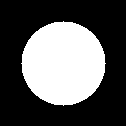

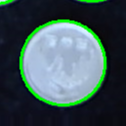

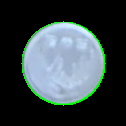

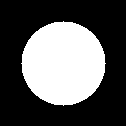

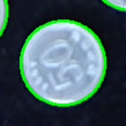

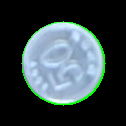

In [13]:
for center, radius in circles[0:2]:
    r = radius * 3
    cen = (r //2, r//2) # 중심 좌표 설정
    mask = np.zeros((r,r,3), np.uint8) # (r,r) 크기의 검정색 빈 마스크를 생성
    cv2.circle(mask, cen, radius, (255,255,255), cv2.FILLED) # 마스크에 흰색 원을 그립니다
    cv2_imshow(mask)
    print()
    coin = cv2.getRectSubPix(image, (r,r), center) # 원본 이미지에서 동전이 위치한 사각형 영역이 추출
    cv2_imshow(coin)
    print()
    # 마스크의 흰색 영역(255,255,255)은 동전의 픽셀 값을 그대로 유지합니다(x AND 255는 항상 x)
    # 마스크의 검정색 영역 (0,0,0)은 동전 영역 바깥의 픽셀 값을 모두 0으로 만들어 검정색으로 처리합니다(x AND 0은 항상 0)
    coin = cv2.bitwise_and(coin,mask)
    cv2_imshow(coin)
    print()

### 이미지에서 동전과 같은 원형 객체를 추출

In [14]:
def make_coin_img(src, circles):
    coins = []
    for center, radius in circles:
        r = radius * 3 # 검출 동전 반지름의 3배, 동전을 추출하는 과정에서 동전 영상이 온전히 포함될 수 있도록 충분한 크기의 마스크를 생성
        cen = (r //2, r//2) # 마스크 중심, 이미지의 가로와 세로 길이의 절반 위치가 정확히 이미지의 중앙
        mask = np.zeros((r,r,3), np.uint8) # 마스크 행렬
        # 주어진 중심(cen), 반지름(radius), 색상((255,255,255), 그리고 채우기 옵션(cv2.FILLED)을 사용, 마스크 이미지 위에 흰색으로 채워진 원을 그립니다)
        cv2.circle(mask, cen, radius, (255,255,255), cv2.FILLED) # 마스크에 흰색 원을 그립니다

        # 동전 영상 가져오기
        coin = cv2.getRectSubPix(src, (r,r), center) # 원본 이미지에서 동전이 위치한 사각형 영역이 추출
        # 마스크에서 흰색으로 표시된 부분(즉, 동전 영역)만이 결과 이미지에 남게 되고, 나머지 배경은 검은색(값이 0)으로 설정
        coin = cv2.bitwise_and(coin,mask) # 마스킹 처리, coin 이미지와 mask 이미지 간의 비트 단위 AND 연산을 수행
        coins.append(coin) # 동전 영상 저장
        # cv2_imshow("mask_"+str(center),mask) # 마스크 영상 보기
    return coins

### 각 동전의 HSV 색상 히스토그램을 계산하는 과정을 수행

In [15]:
def calc_histo_hue(coin):
    hsv = cv2.cvtColor(coin, cv2.COLOR_BGR2HSV) # 컬러 공간 변환
    hsize, ranges = [32], [0,180] # 32개의 빈을 사용하여 색상 범위를 나누고 HSV에서 색상 값은 0에서 179 사이
    hist = cv2.calcHist([hsv],[0],None, hsize, ranges) # 0은 HSV이미지의 첫 번쨰 채널, 즉 색상(hue) 채널을 의미, hsize : 각 차원별 빈(bin)의 개수
    return hist.flatten()

### 색상 팔레트 생성 함수(mask_palate)

In [16]:
# 주어진 행의 수(rows)에 대응하는 HSV 색상 팔레트를 생성하고, 이를 BGR 색상 공간으로 변환하는 과정을 구현
def make_palate(rows):
    hue = [round(i * 180 / rows) for i in range(rows)] # 전체 hue 범위를 rows의 수만큼 균일하게 나누어 각 hue 값을 계산,
    # hue 값의 범위는 일반적으로 0에서 180까지의 범위를 가집니다.
    hsv = [[(h,255,255) for h in hue]] # 계산된 hue 값에 대해 채도(Saturation)와 명도(Value)를 최대값인 255로 설정하여 HSV 색상을 생성
    hsv = np.array(hsv,np.uint8) # numpy 행렬의 unit8형 변환
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR) # HSV 컬러 -> BGR 컬러